In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
import kerastuner as kt 
import IPython 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'cartbox', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'boxcox', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 7.958078640513122e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(80000, 6, 5) (80000, 6) (80000, 9)
(20000, 6, 5) (20000, 6) (20000, 9)


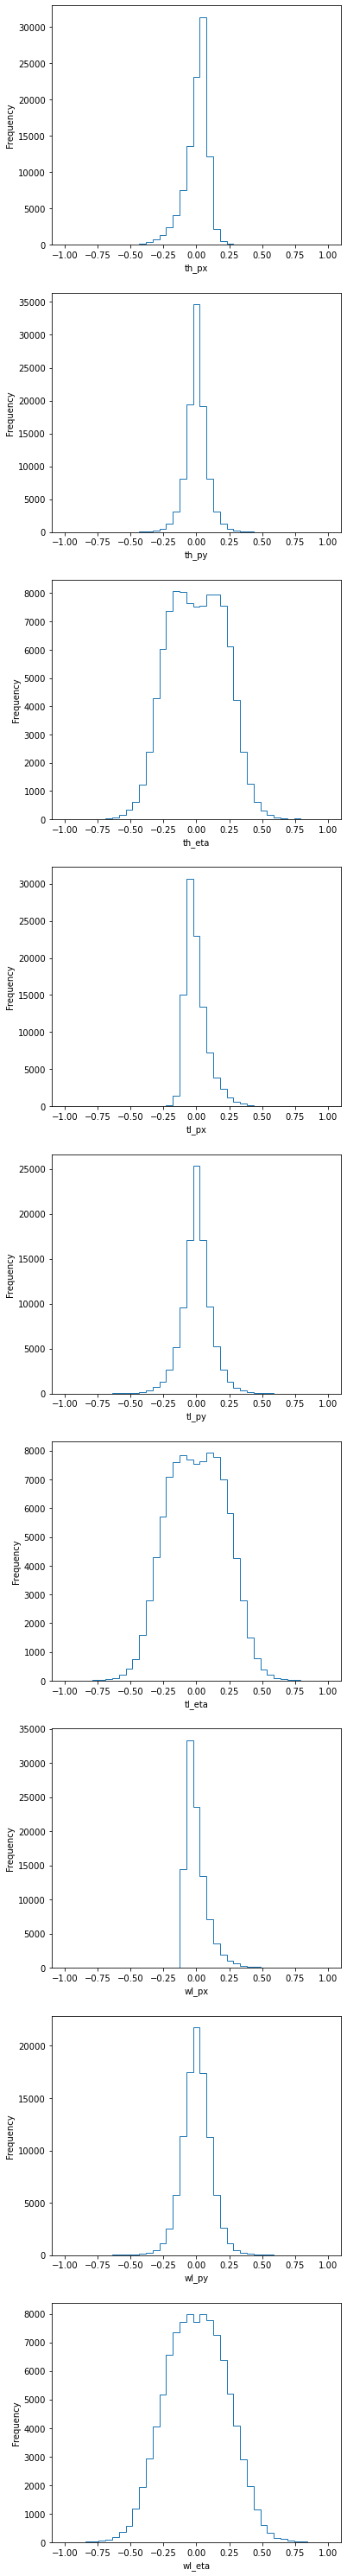

In [4]:
# Histograms of total  Y variables 
show = True

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

# def build_model():
#     jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
#     Mask = Masking(-2)(jet_input)
#     LSTM11 = LSTM(64, return_sequences=True)(Mask)
#     LSTM12 = LSTM(64, return_sequences=True)(LSTM11)
    
#     flat_jets = Flatten()(LSTM12)
    
#     other_input = Input(shape=(trainX_other.shape[1]))
#     Dense21 = Dense(64, activation='relu')(other_input)
#     flat_other = Flatten()(Dense21)
    
#     concat = concatenate([flat_other, flat_jets])
#     dense1 = Dense(256, activation='relu')(concat)
#     dense2 = Dense(128, activation='relu')(dense1)
#     output = Dense(len(Y_names), activation='linear')(dense2)
    
#     model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
#     optimizer = keras.optimizers.Adam(learning_rate=5e-5)
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 

def model_builder(hp):
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    LSTM11 = LSTM(hp.Int('input_units', min_value=32, max_value=256, step=32), return_sequences=True)(Mask)
    LSTM12 = LSTM(hp.Int('input_units', min_value=32, max_value=256, step=32), return_sequences=True)(LSTM11)
    flat_jets = Flatten()(LSTM12)
    
    other_input = Input(shape=(trainX_other.shape[1]))
    Dense21 = Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu')(other_input)
    flat_other = Flatten()(Dense21)
    
    concat = concatenate([flat_other, flat_jets])
    dense1 = Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu')(concat)
    dense2 = Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 5e-5,1e-5,5e-6,1e-6]))
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model

tuner = kt.Hyperband(model_builder, objective='val_mse', max_epochs=512,factor=3)



INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [7]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search([trainX_jets, trainX_other], trainY, epochs = 10, validation_data = ([testX_jets, testX_other], testY), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

INFO:tensorflow:Oracle triggered exit


ValueError: Unknown parameter: units

In [8]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)


callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
Epochs= 512
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)

Train on 64000 samples, validate on 16000 samples
Epoch 1/512
64000/64000 [==============================] - ETA: 13:24 - loss: 0.0228 - mse: 0.02 - ETA: 3:17 - loss: 0.0227 - mse: 0.0227 - ETA: 1:51 - loss: 0.0222 - mse: 0.022 - ETA: 1:16 - loss: 0.0217 - mse: 0.021 - ETA: 57s - loss: 0.0216 - mse: 0.021 - ETA: 46s - loss: 0.0210 - mse: 0.02 - ETA: 38s - loss: 0.0206 - mse: 0.02 - ETA: 32s - loss: 0.0202 - mse: 0.02 - ETA: 27s - loss: 0.0199 - mse: 0.01 - ETA: 24s - loss: 0.0195 - mse: 0.01 - ETA: 21s - loss: 0.0190 - mse: 0.01 - ETA: 19s - loss: 0.0186 - mse: 0.01 - ETA: 17s - loss: 0.0182 - mse: 0.01 - ETA: 15s - loss: 0.0178 - mse: 0.01 - ETA: 13s - loss: 0.0174 - mse: 0.01 - ETA: 12s - loss: 0.0170 - mse: 0.01 - ETA: 11s - loss: 0.0167 - mse: 0.01 - ETA: 10s - loss: 0.0163 - mse: 0.01 - ETA: 9s - loss: 0.0160 - mse: 0.0160 - ETA: 8s - loss: 0.0157 - mse: 0.015 - ETA: 8s - loss: 0.0154 - mse: 0.015 - ETA: 7s - loss: 0.0152 - mse: 0.015 - ETA: 6s - loss: 0.0150 - mse: 0.015 - ETA: 6

64000/64000 [==============================] - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 2s - loss: 0.0065 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 2s - loss: 0.0067 - mse: 0.006 - ETA: 1s - loss: 0.0067 - mse: 0.006 - ETA: 1s - loss: 0.0067 - mse: 0.006 - ETA: 1s - loss: 0.0067 - mse: 0.006 - ETA: 1s - loss: 0.0067 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA: 1s - loss: 0.0067 - mse: 0.006 - ETA: 1s - loss: 0.0067 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA: 1s - loss: 0.0066 - mse: 0.006 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0061 - mse: 0.006 - ETA: 2s - loss: 0.0063 - mse: 0.006 - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 2s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA: 1s - loss: 0.0064 - mse: 0.006 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0059 - mse: 0.005 - ETA: 2s - loss: 0.0061 - mse: 0.006 - ETA: 2s - loss: 0.0062 - mse: 0.006 - ETA: 2s - loss: 0.0062 - mse: 0.006 - ETA: 2s - loss: 0.0062 - mse: 0.006 - ETA: 2s - loss: 0.0062 - mse: 0.006 - ETA: 2s - loss: 0.0062 - mse: 0.006 - ETA: 2s - loss: 0.0062 - mse: 0.006 - ETA: 2s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA: 1s - loss: 0.0062 - mse: 0.006 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0059 - mse: 0.005 - ETA: 2s - loss: 0.0060 - mse: 0.006 - ETA: 2s - loss: 0.0059 - mse: 0.005 - ETA: 2s - loss: 0.0060 - mse: 0.006 - ETA: 2s - loss: 0.0060 - mse: 0.006 - ETA: 2s - loss: 0.0060 - mse: 0.006 - ETA: 2s - loss: 0.0060 - mse: 0.006 - ETA: 2s - loss: 0.0060 - mse: 0.006 - ETA: 2s - loss: 0.0060 - mse: 0.006 - ETA: 2s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0060 - mse: 0.006 - ETA: 1s - loss: 0.0059 - mse: 0.005 - ETA: 1s - loss: 0.0059 - mse: 0.005 - ETA: 1s - loss: 0.0059 - mse: 0.005 - ETA: 1s - loss: 0.0059 - mse: 0.005 - ETA: 1s - loss: 0.0059 - mse: 0.005 - ETA: 1s - loss: 0.0059 - mse: 0.005 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0054 - mse: 0.005 - ETA: 2s - loss: 0.0056 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 2s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0058 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA: 1s - loss: 0.0057 - mse: 0.005 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0054 - mse: 0.005 - ETA: 2s - loss: 0.0055 - mse: 0.005 - ETA: 2s - loss: 0.0055 - mse: 0.005 - ETA: 2s - loss: 0.0055 - mse: 0.005 - ETA: 2s - loss: 0.0055 - mse: 0.005 - ETA: 2s - loss: 0.0055 - mse: 0.005 - ETA: 2s - loss: 0.0055 - mse: 0.005 - ETA: 2s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0056 - mse: 0.005 - ETA: 1s - loss: 0.0056 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA: 1s - loss: 0.0055 - mse: 0.005 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 2s - loss: 0.0053 - mse: 0.005 - ETA: 2s - loss: 0.0054 - mse: 0.005 - ETA: 2s - loss: 0.0053 - mse: 0.005 - ETA: 2s - loss: 0.0054 - mse: 0.005 - ETA: 2s - loss: 0.0054 - mse: 0.005 - ETA: 2s - loss: 0.0054 - mse: 0.005 - ETA: 2s - loss: 0.0054 - mse: 0.005 - ETA: 2s - loss: 0.0053 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0053 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA: 1s - loss: 0.0054 - mse: 0.005 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 2s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA: 1s - loss: 0.0052 - mse: 0.005 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 2s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0051 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 2s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0050 - mse: 0.005 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 2s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0049 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0048 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0048 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0047 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0047 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0046 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0046 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0045 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0045 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0044 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0044 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA

64000/64000 [==============================] - ETA: 2s - loss: 0.0041 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0043 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 2s - loss: 0.0042 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA: 1s - loss: 0.0043 - mse: 0.004 - ETA

In [22]:
print("Learning rate: "best_hps.get('learning_rate'))
model.summary()

0.0001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 6, 5)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 224)       206080      masking[0][0]                    
_______________________________________________________________________________________

Text(0.5, 1.0, 'MSE loss')

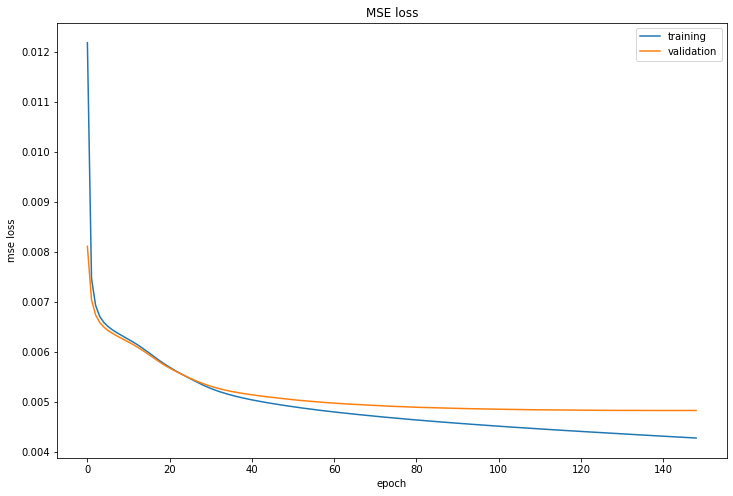

In [9]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [10]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=self.crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi, bins):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
            plt.hist(diff, hbins, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi, bins): 
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
                
            plt.hist(true_small, hbins, histtype='step', color='b', label='true values', density=False)
            plt.hist(compare_small, hbins, histtype='step', color='r', label='predictions', density=False)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')
    
    def predicted_vs_true(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], compare[:, i], 'o', color='g', markersize=2)
            line = np.linspace(np.min(true[:, i]), np.max(true[:, i]), 100)
            plt.plot(line, line, color='b')
            plt.xlabel('True')
            plt.title(names[i])
            plt.ylabel('Predicted')

In [11]:
display = Analysis()

predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [12]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.004857425328711141
 
th_px MSE :  0.0027430353
th_py MSE :  0.0029473463
th_eta MSE :  0.0105055910
tl_px MSE :  0.0016409381
tl_py MSE :  0.0043291434
tl_eta MSE :  0.0088084904
wl_px MSE :  0.0012014866
wl_py MSE :  0.0029372279
wl_eta MSE :  0.0086035689


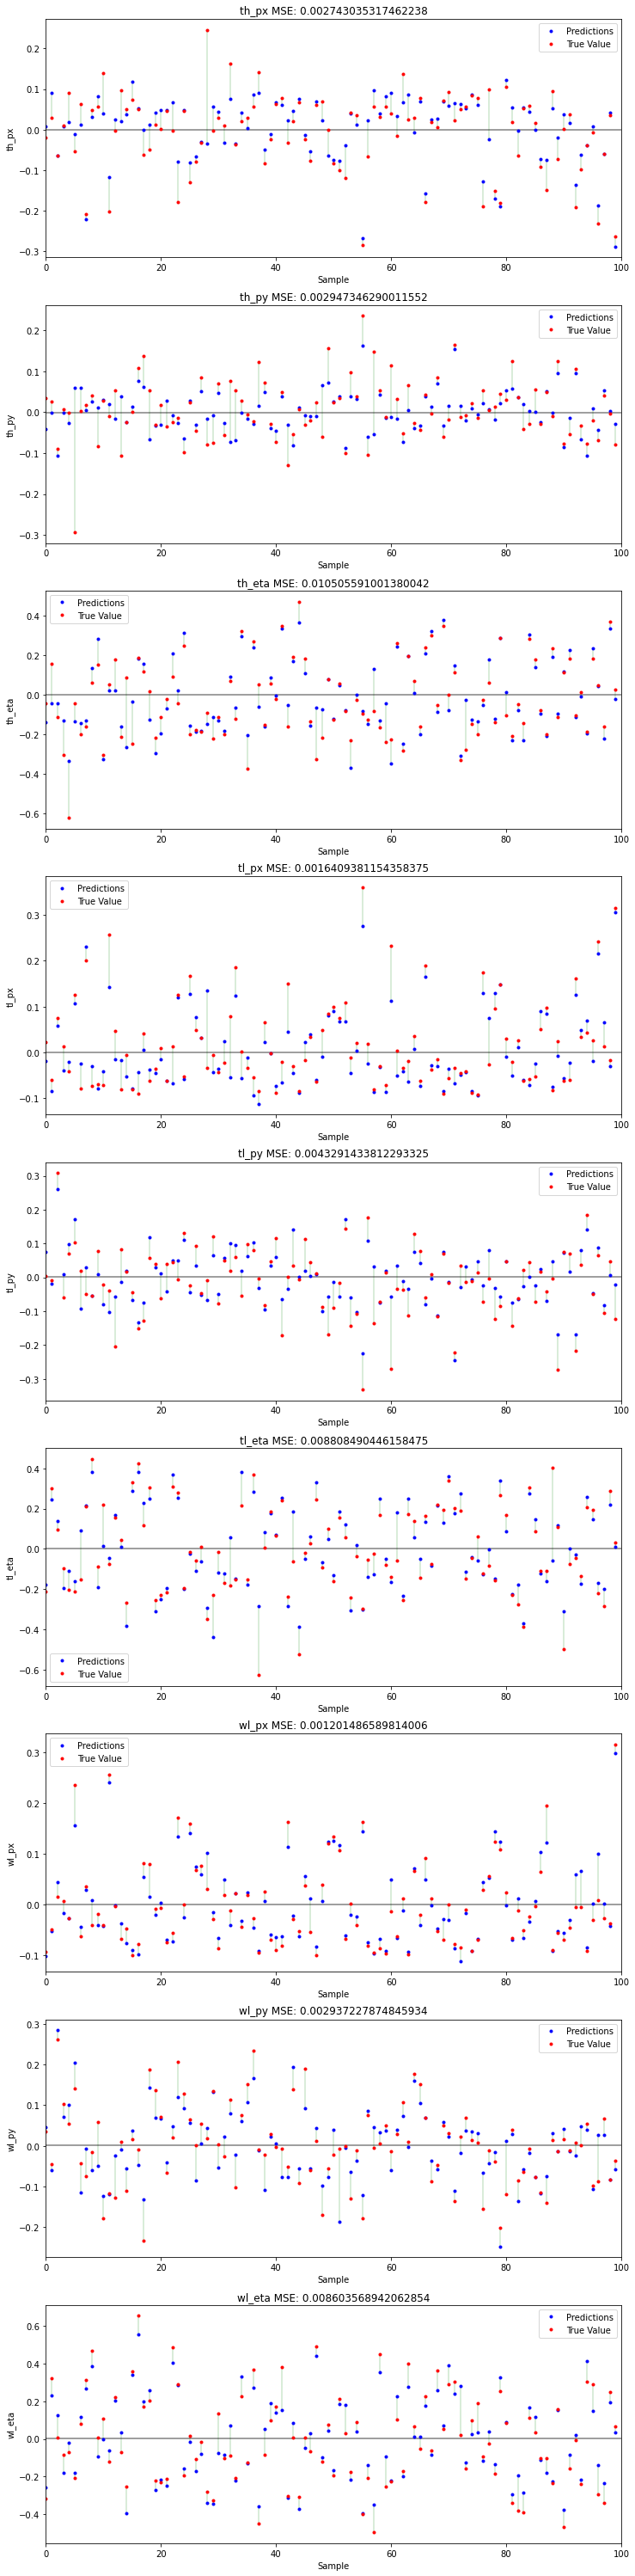

In [13]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

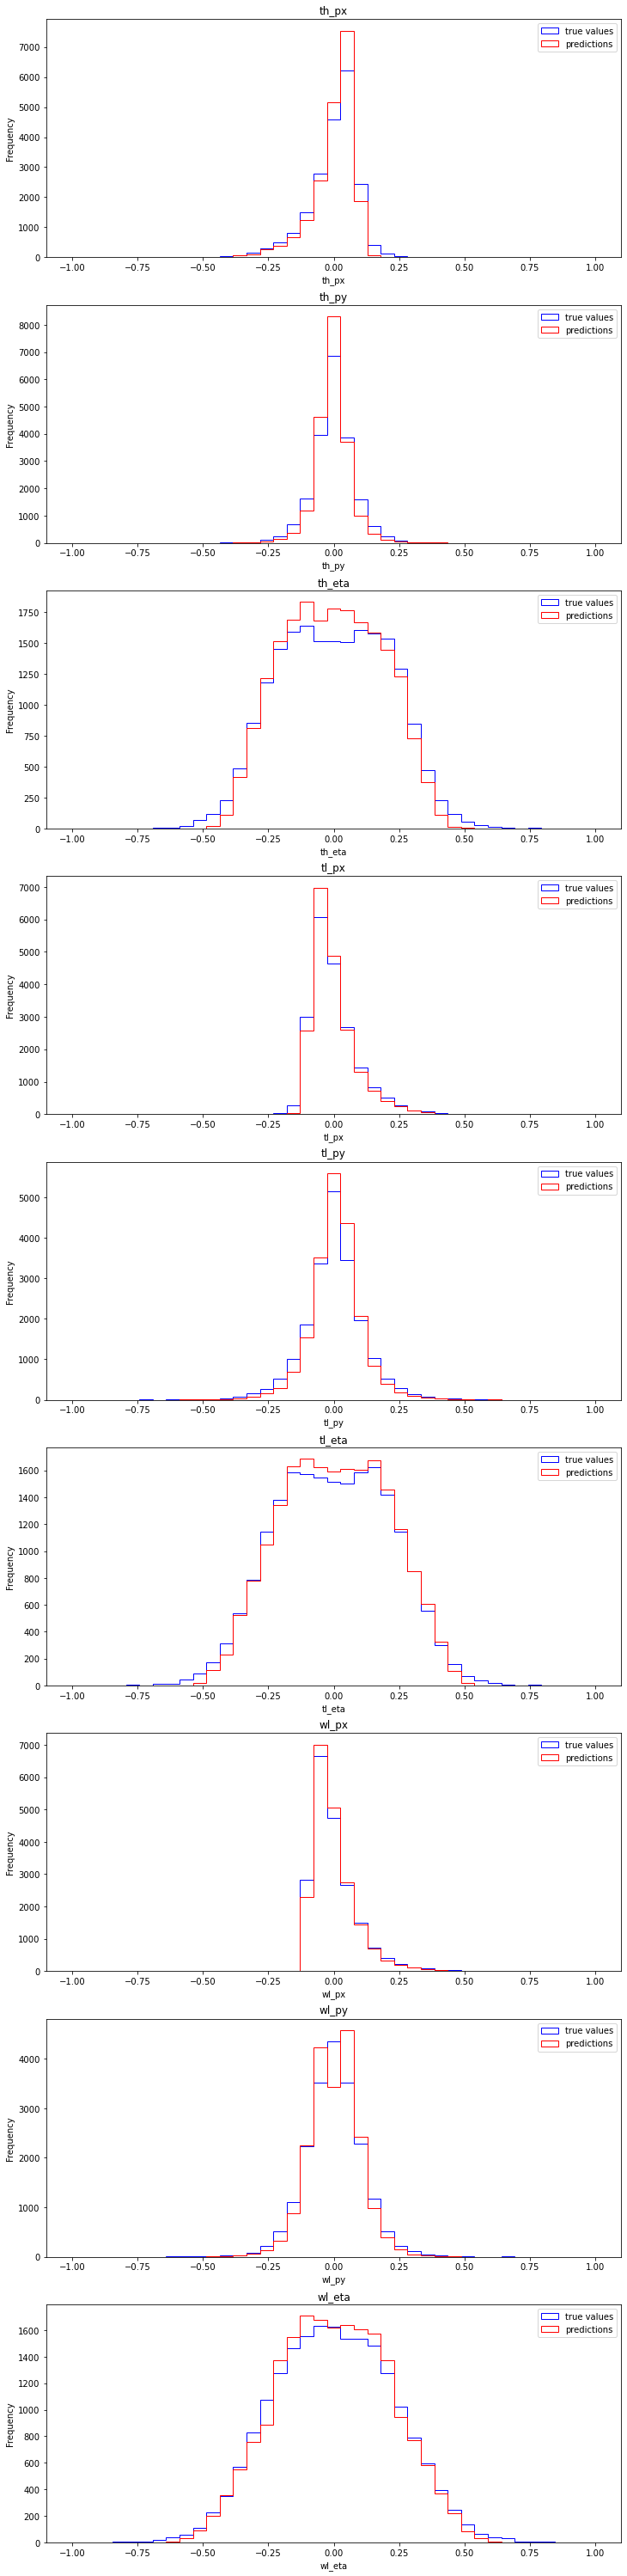

In [14]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

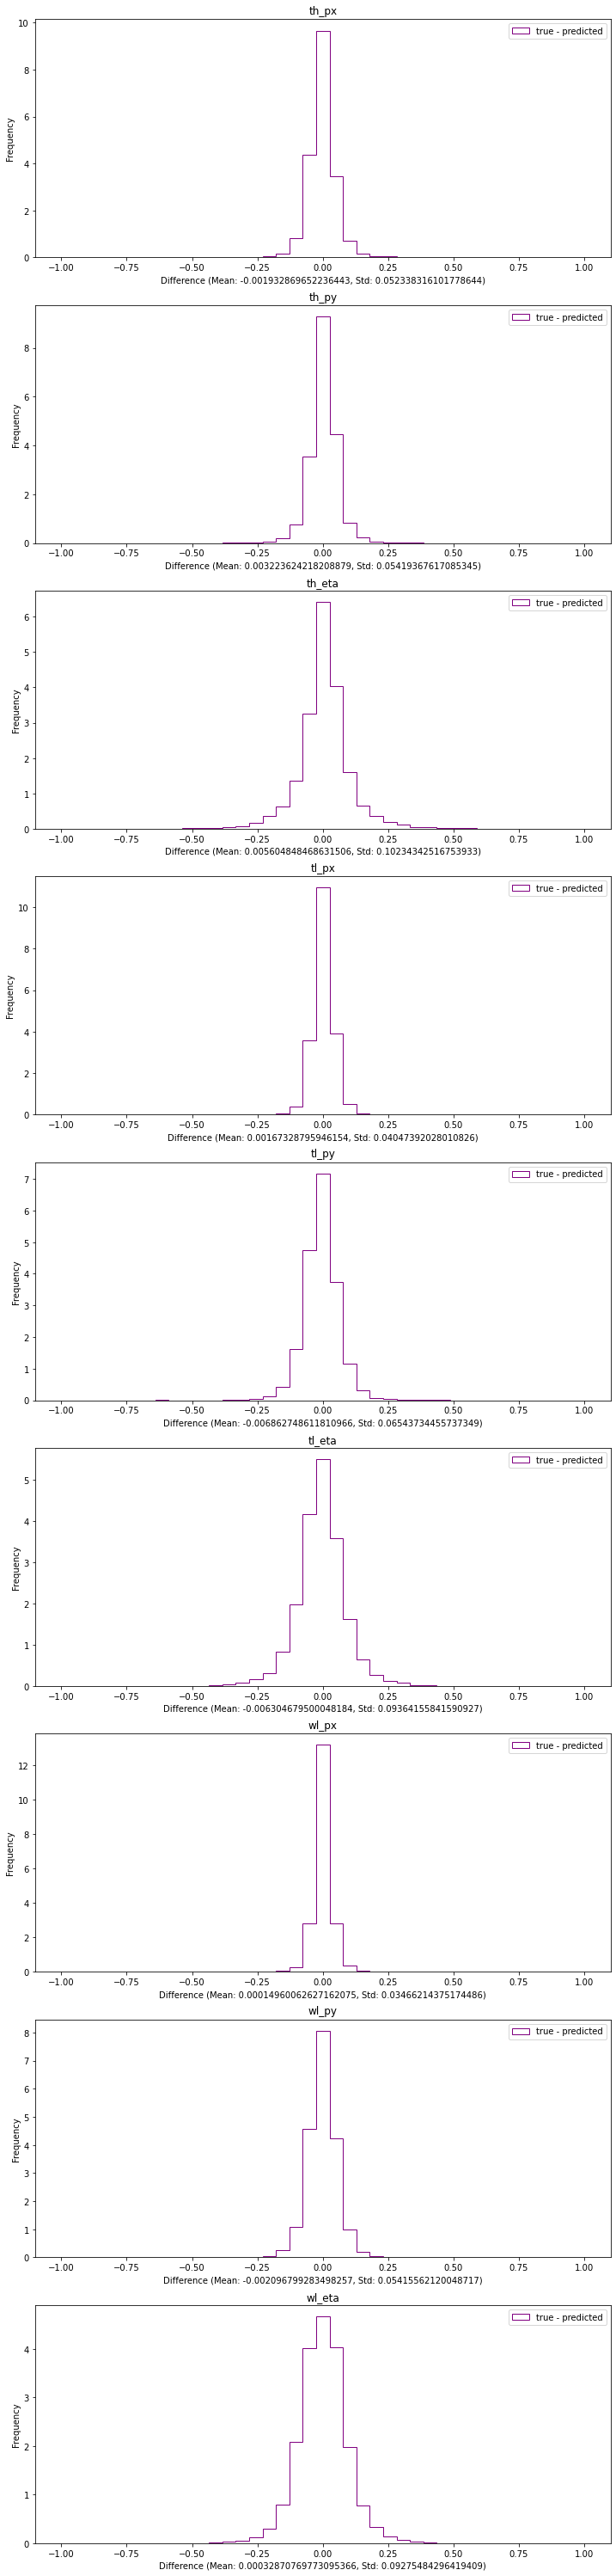

In [15]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

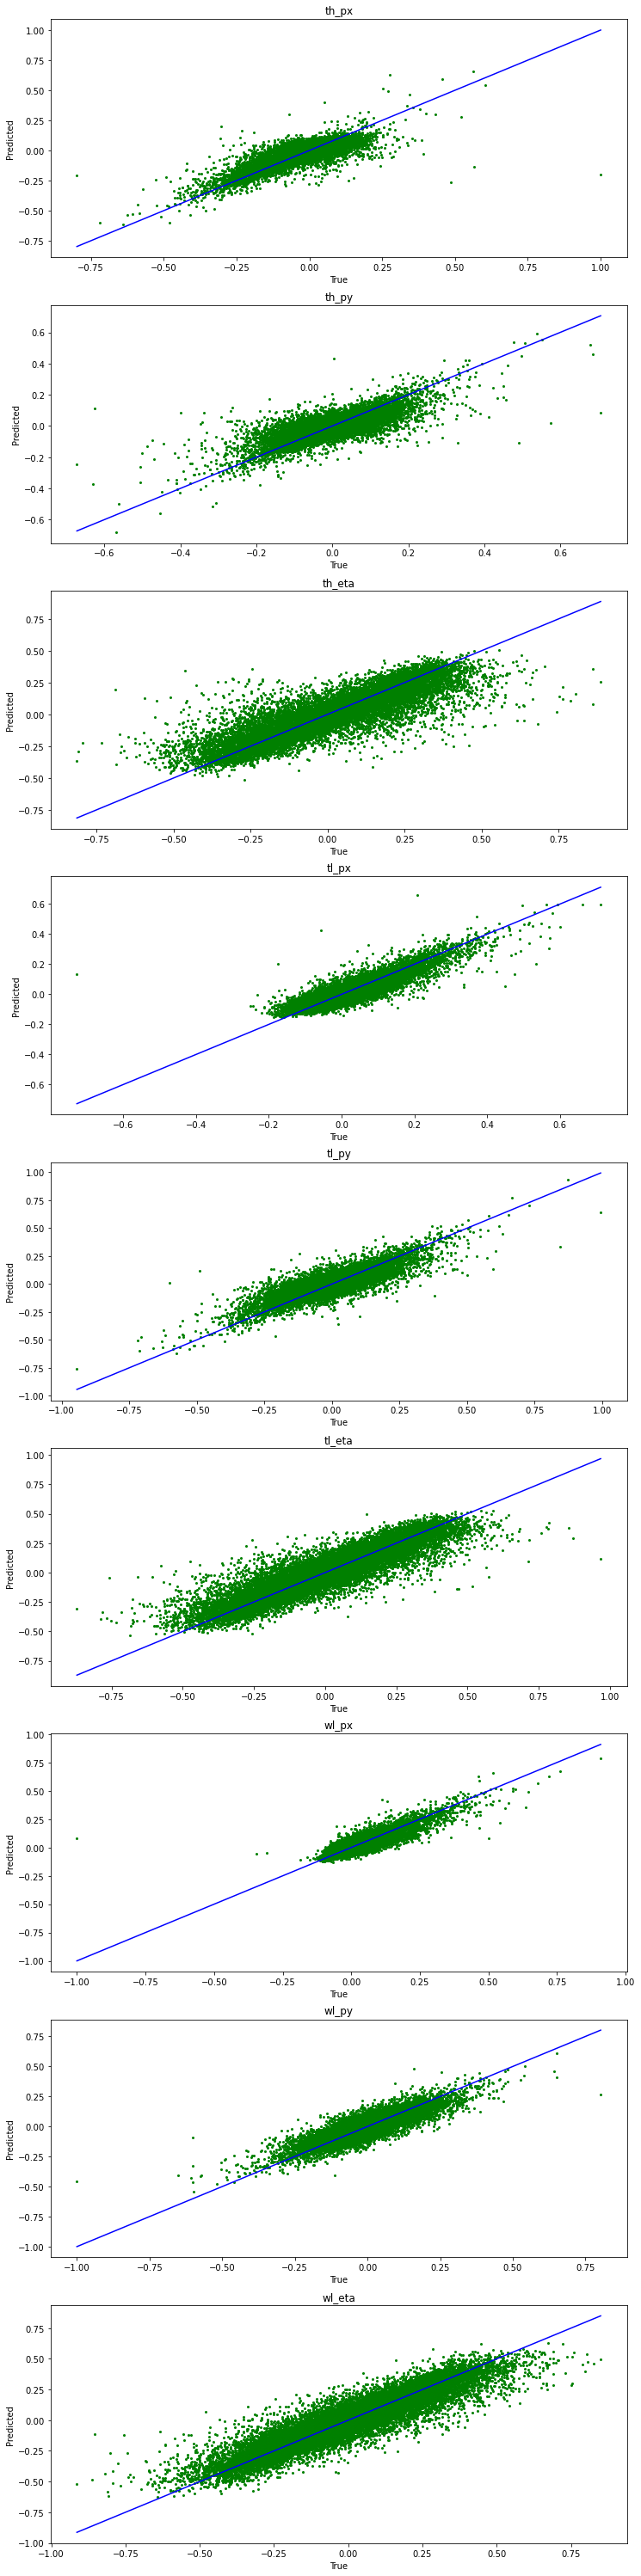

In [16]:
display.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [17]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 509.71815370286913
 
th_pt MSE :  2359.6045382474
th_eta MSE :  0.5779111730
th_phi MSE :  0.9624947017
tl_pt MSE :  1587.9250157985
tl_eta MSE :  0.4407868277
tl_phi MSE :  0.6033977856
wl_pt MSE :  631.6367005394
wl_eta MSE :  0.3074649817
wl_phi MSE :  0.2207733135


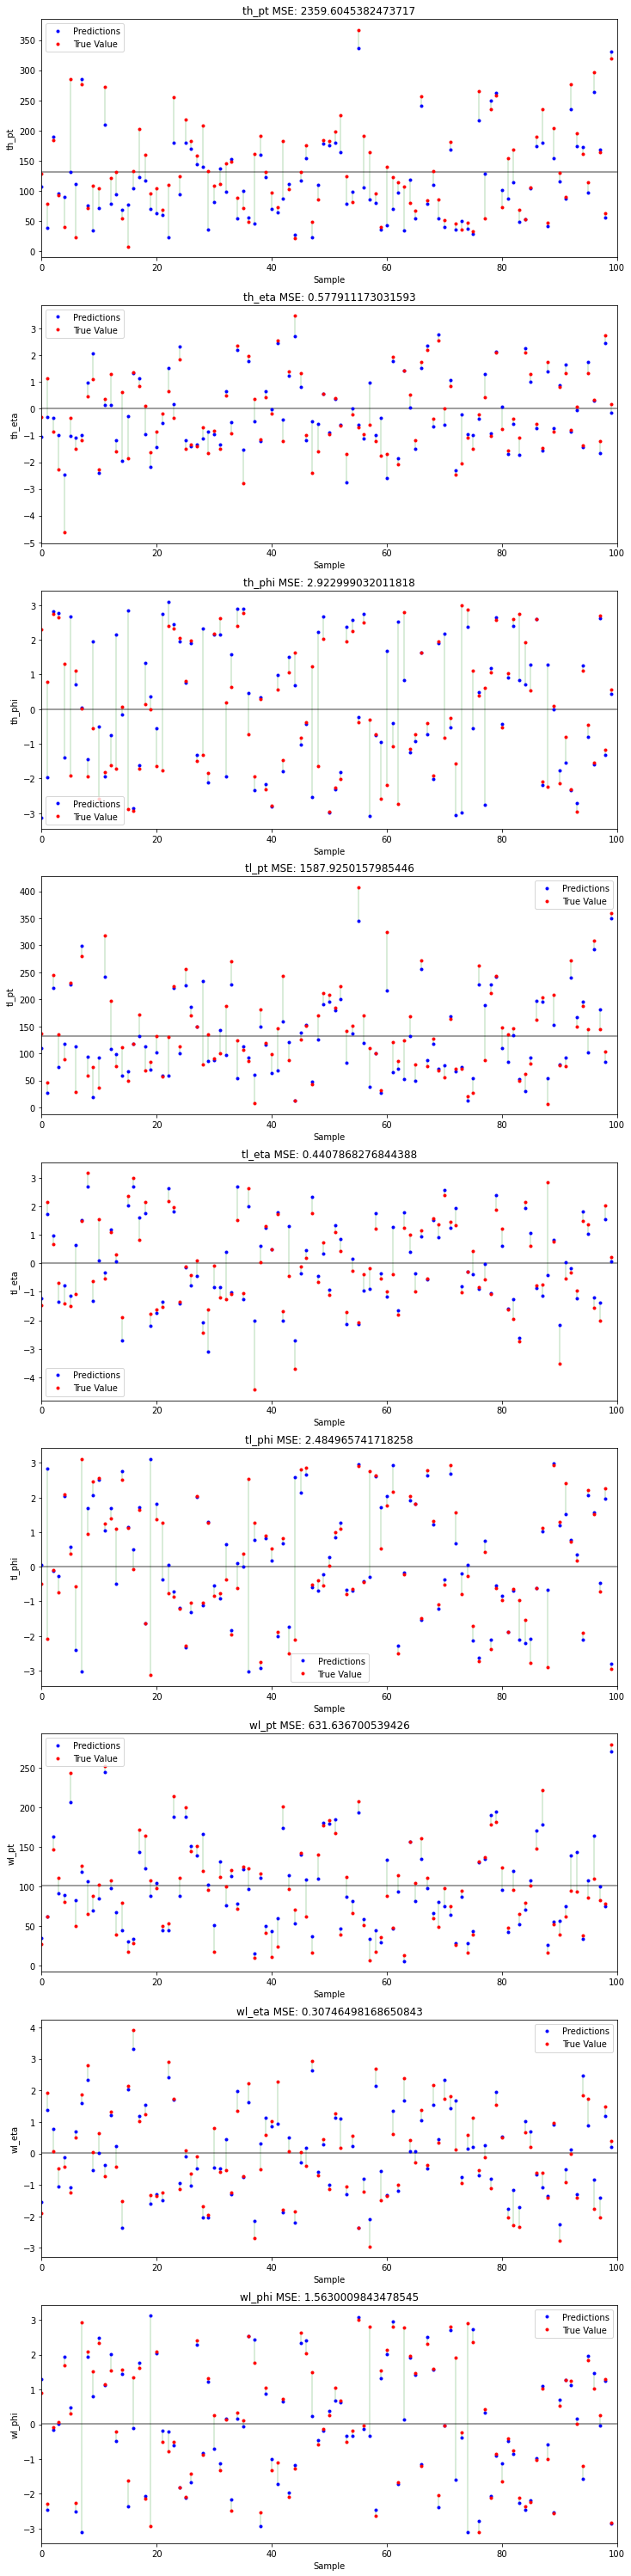

In [18]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

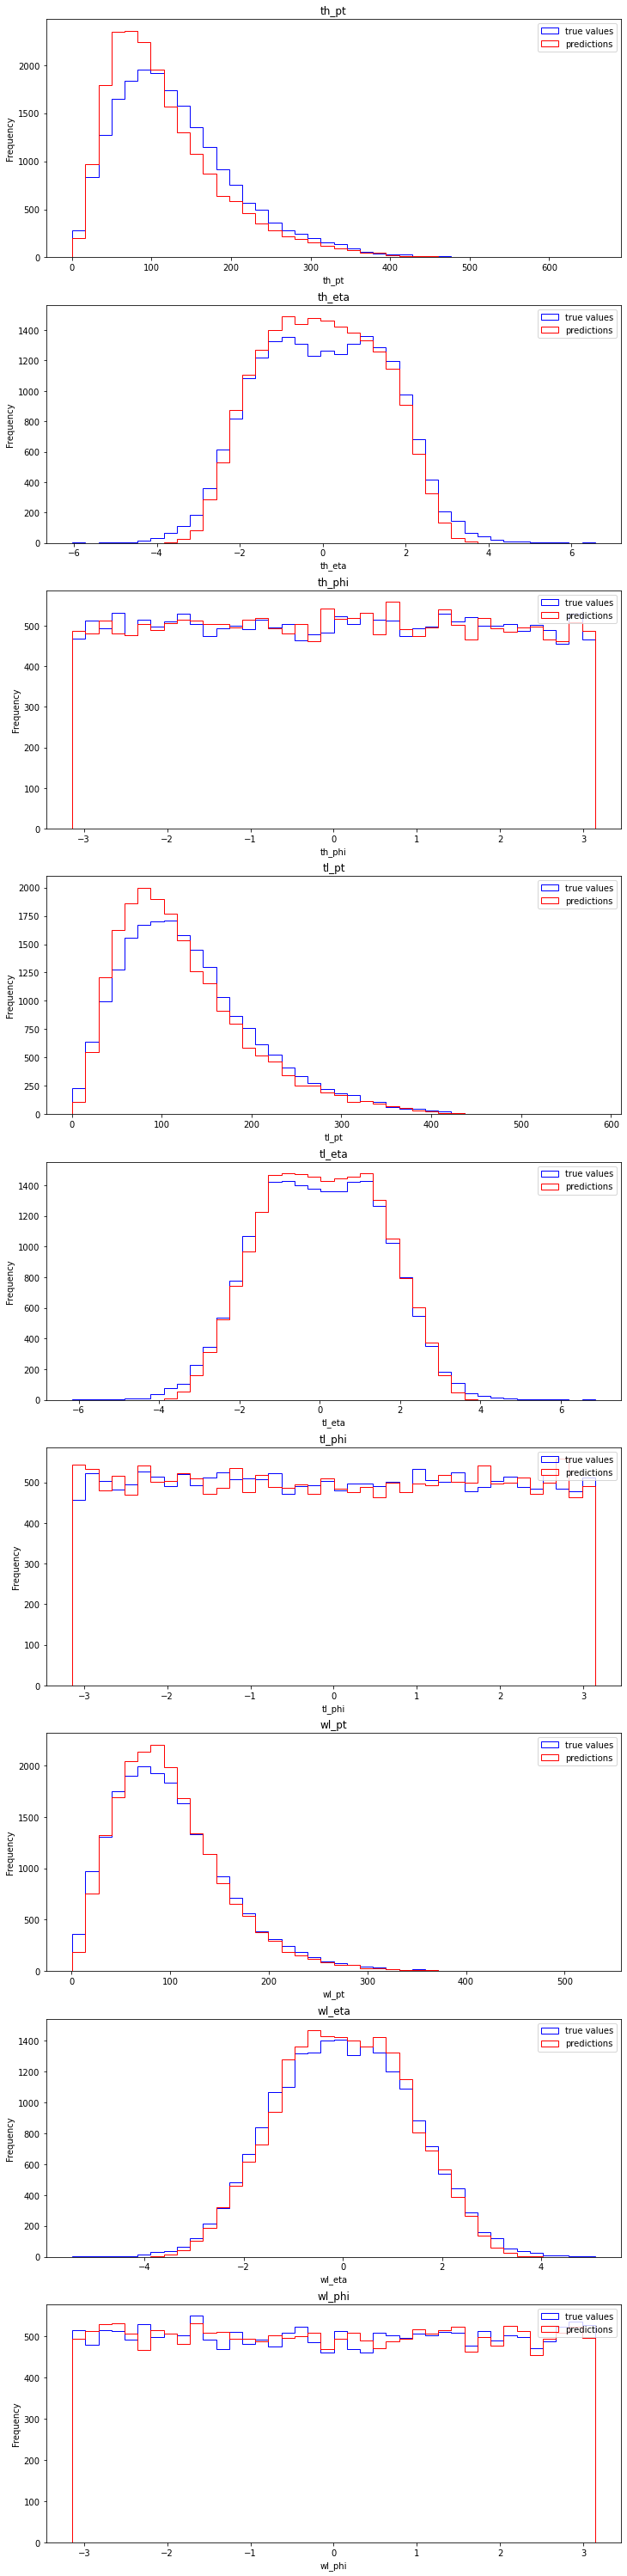

In [19]:
display.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

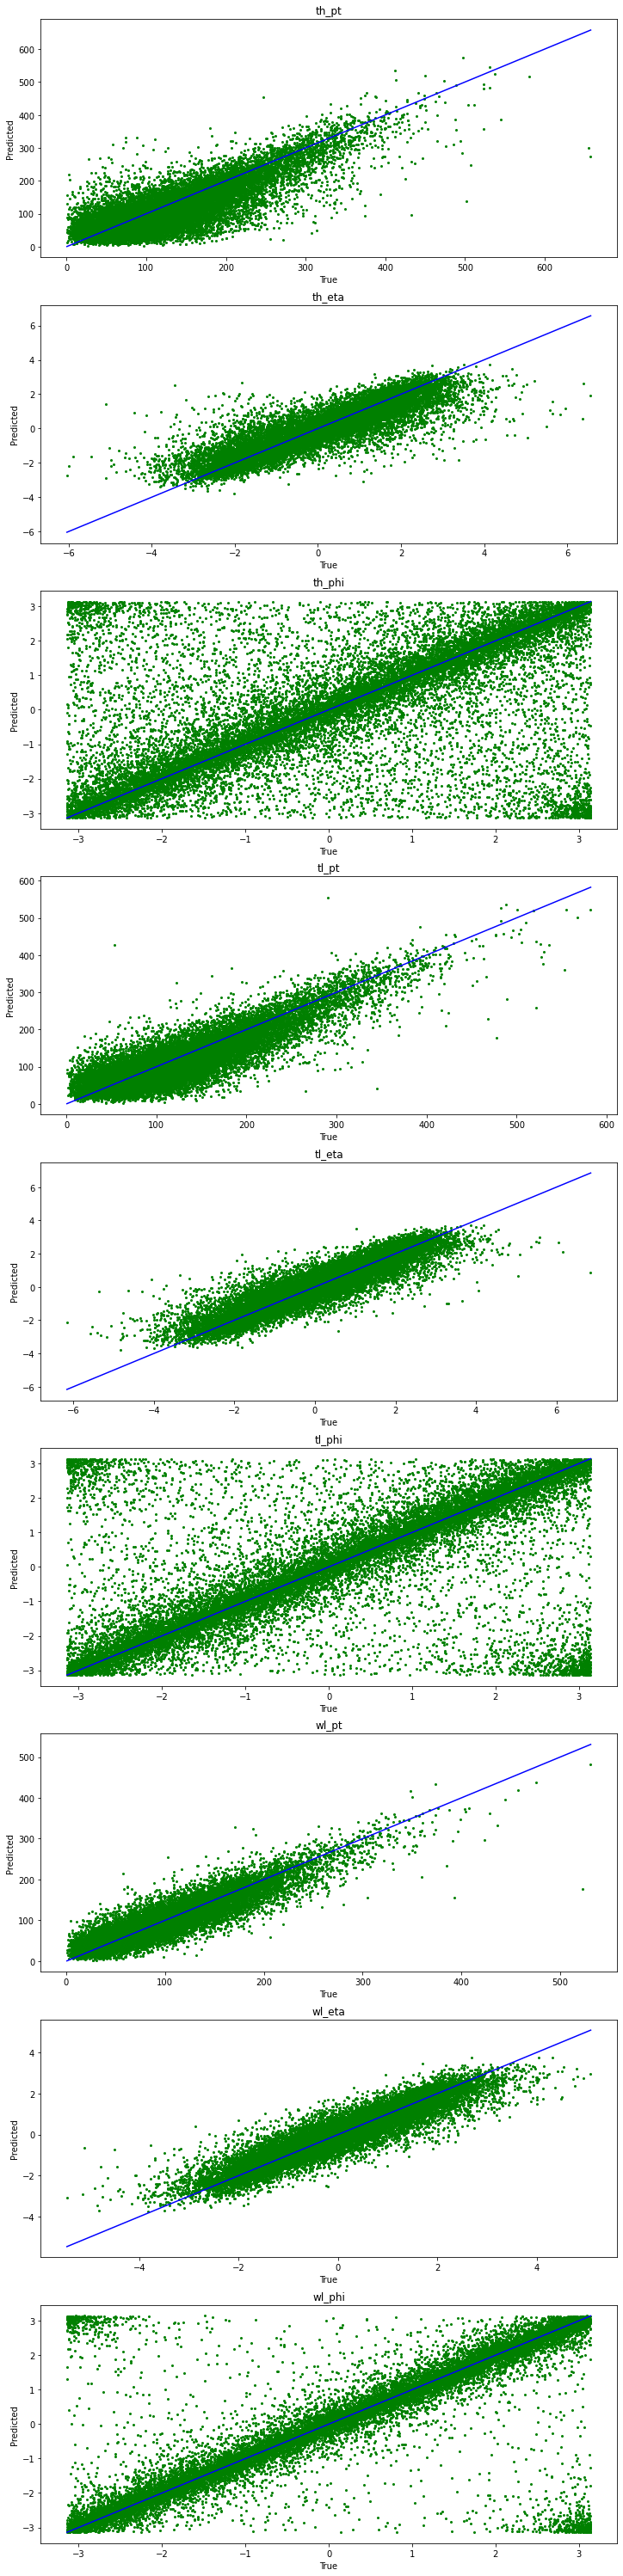

In [20]:
display.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)